<a href="https://colab.research.google.com/github/pschofield2/machine_learning/blob/main/predicting_nfl_play_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting if the Bengals' next play will be a pass or a run using NFL play by play data

## Data Prep

### Import Libraries and NFL Play by Play Data

In [51]:
!pip install nfl_data_py --upgrade --quiet

In [52]:
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import re
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',20)
pd.set_option('display.max_colwidth', None)
sns.set_style('darkgrid');

In [53]:
# Import Data
df = nfl.import_pbp_data([2022])
df.head(1)

2022 done.
Downcasting floats.


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tack

### Inspect Data

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50147 entries, 0 to 50146
Columns: 384 entries, play_id to n_defense
dtypes: float32(202), int32(8), int64(1), object(173)
memory usage: 106.7+ MB


In [55]:
# inspect size
print(df.size)

19256448


In [56]:
# inspect shape
print(df.shape)

(50147, 384)


In [57]:
# total missing nulls
df.isnull().sum().sum()

6925126

In [58]:
# checking nulls
null = df.isnull().sum()
for index, val in null.items():
  if val > 0:
    print(index,val)


posteam 3720
posteam_type 3720
defteam 3720
side_of_field 4287
yardline_100 4243
drive 450
down 8543
yrdln 344
ydsnet 450
play_type 2162
yards_gained 2206
qb_dropback 2162
pass_length 31208
pass_location 31208
air_yards 31150
yards_after_catch 37946
run_location 35266
run_gap 38991
field_goal_result 49042
kick_distance 44907
extra_point_result 48894
two_point_conv_result 50019
timeout 2206
timeout_team 47936
td_team 48757
td_player_name 48757
td_player_id 48759
posteam_timeouts_remaining 3720
defteam_timeouts_remaining 3720
posteam_score 3720
defteam_score 3720
score_differential 3720
posteam_score_post 3720
defteam_score_post 3720
score_differential_post 3720
ep 568
epa 568
air_epa 31207
yac_epa 31207
comp_air_epa 2209
comp_yac_epa 2209
wp 284
def_wp 284
wpa 729
vegas_wpa 729
vegas_home_wpa 284
home_wp_post 4197
away_wp_post 4197
vegas_wp 284
air_wpa 31207
yac_wpa 31207
comp_air_wpa 2209
comp_yac_wpa 2209
punt_blocked 2206
first_down_rush 2206
first_down_pass 2206
first_down_penalty 2

In [59]:
# check data types
df.dtypes

play_id            float32
game_id             object
old_game_id         object
home_team           object
away_team           object
                    ...   
players_on_play     object
offense_players     object
defense_players     object
n_offense            int32
n_defense            int32
Length: 384, dtype: object

### Preprocessing and Feature Engineering

Features we want to include, at the minimum:



*   Down
*   Distance
*   Score differential
*   Possession Team
*   Seconds remaining in half
*   Yardline
*   Timeouts remaining
*   Roof/No Roof

Features that would be nice to include:
*   Wind MPH
*   Weather conditions
*   Last Play Type
*   Yards gained from last play

In the real world, I would not have enough time to input all of these variables between plays. Including as many as I can now though for curiosity, then goal is to trim down to a few features.



In [60]:
# Extract Wind MPH
df['wind_mph'] = df['weather'].str[-6:].str.split('mph').str[0].str.strip(' ')
df['wind_mph'] = df['wind_mph'].replace(to_replace = ':',value=None)
df['wind_mph'] = df['wind_mph'].astype('Int64')
df.head(1)

<ipython-input-60-bd84955bf069>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['wind_mph'] = df['weather'].str[-6:].str.split('mph').str[0].str.strip(' ')


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tack

<AxesSubplot:>

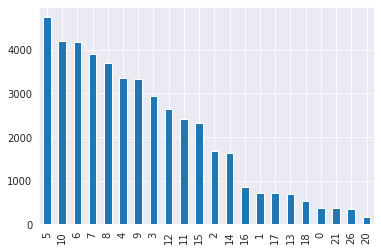

In [61]:
# visualizing wind MPH
df['wind_mph'].value_counts().plot(kind = 'bar')

In [62]:
# filter on CIN and only pass or run plays
df = df[(df['posteam']=='CIN') & (df['penalty_team'].isna()) & (df['two_point_conv_result'].isna()) & (df['play_type'].isin(['pass','run']))]

Visualizing Target Variable

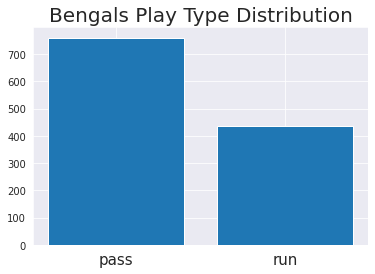

In [63]:
# visualize play type distribution
#df['play_type'].value_counts().plot(kind='bar')
play_type_counts = df.groupby('play_type').count()['play_id']
plt.bar(play_type_counts.index,play_type_counts)
plt.title('Bengals Play Type Distribution', fontsize = 20)
plt.xticks(fontsize=15);

pass    0.635983
run     0.364017
Name: play_type, dtype: float64


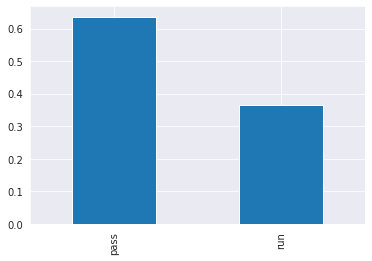

In [64]:
df['play_type'].value_counts(normalize = True).plot(kind = 'bar')
print(df['play_type'].value_counts(normalize = True))

The Bengals passed 64% of the time and ran the ball 36% of the time. In order to beat baseline, model needs to beat 64% accuracy (because you could just guess pass every time and be right 64% of the time).

Convert target variable from string to boolean (1 = pass, 0 = run)

In [65]:
# make play_type binary
# pass = 1, run = 0
is_pass = []
for _, row in df.iterrows():
  if row['play_type'] == 'pass':
    is_pass.append(1)
  else:
    is_pass.append(0)

df['is_pass'] = is_pass
df['is_pass'].value_counts()

1    760
0    435
Name: is_pass, dtype: int64

In [66]:
### Work in progress to parse out weather description ###

# rain = []
# for _, row in df.iterrows():
#   if 'rain' in row['weather'].lower():
#     rain.append(1)
#   else:
#     rain.append(0)

# df['rained'] = rain
# df.head(1)


# pat = re.compile("(.*?)Temp\:\s(\d+)\°\sF(?:.*?)(\d+)\%(?:.*?)Wind\:\s([NWSE])\s(\d+)\smph")
# result = pat.match("Rain and mid 70s Temp: 73° F, Humidity: 79%, Wind: W 3 mph")
# result

In [67]:
# feature selection
columns = ['game_id','play_id','drive','yardline_100','week','half_seconds_remaining','game_seconds_remaining','season_type','qtr',
           'down','ydstogo','goal_to_go','location','offense_formation','score_differential',
           'posteam_timeouts_remaining','is_pass']

df = df[columns]

In [68]:
df.head(3)

,game_id,play_id,drive,yardline_100,week,half_seconds_remaining,game_seconds_remaining,season_type,qtr,down,ydstogo,goal_to_go,location,offense_formation,score_differential,posteam_timeouts_remaining,is_pass
2327,2022_01_PIT_CIN,176.0,2.0,78.0,1,1711.0,3511.0,REG,1.0,1.0,10.0,0.0,Home,EMPTY,0.0,3.0,1
2328,2022_01_PIT_CIN,195.0,2.0,83.0,1,1672.0,3472.0,REG,1.0,2.0,15.0,0.0,Home,SHOTGUN,0.0,3.0,1
2331,2022_01_PIT_CIN,253.0,3.0,75.0,1,1663.0,3463.0,REG,1.0,1.0,10.0,0.0,Home,SHOTGUN,-7.0,3.0,0


Convert categorical variables into dummy boolean variables for better performance

In [69]:
df = pd.get_dummies(df, columns = ['season_type','location','offense_formation'])
df.head()

,game_id,play_id,drive,yardline_100,week,half_seconds_remaining,game_seconds_remaining,qtr,down,ydstogo,goal_to_go,score_differential,posteam_timeouts_remaining,is_pass,season_type_POST,season_type_REG,location_Home,offense_formation_EMPTY,offense_formation_I_FORM,offense_formation_JUMBO,offense_formation_PISTOL,offense_formation_SHOTGUN,offense_formation_SINGLEBACK
2327,2022_01_PIT_CIN,176.0,2.0,78.0,1,1711.0,3511.0,1.0,1.0,10.0,0.0,0.0,3.0,1,0,1,1,1,0,0,0,0,0
2328,2022_01_PIT_CIN,195.0,2.0,83.0,1,1672.0,3472.0,1.0,2.0,15.0,0.0,0.0,3.0,1,0,1,1,0,0,0,0,1,0
2331,2022_01_PIT_CIN,253.0,3.0,75.0,1,1663.0,3463.0,1.0,1.0,10.0,0.0,-7.0,3.0,0,0,1,1,0,0,0,0,1,0
2332,2022_01_PIT_CIN,274.0,3.0,70.0,1,1625.0,3425.0,1.0,2.0,5.0,0.0,-7.0,3.0,0,0,1,1,0,0,0,0,0,1
2333,2022_01_PIT_CIN,295.0,3.0,64.0,1,1594.0,3394.0,1.0,1.0,10.0,0.0,-7.0,3.0,1,0,1,1,1,0,0,0,0,0


More preprocessing

In [70]:
# Convert float variables to integers
float_columns = ['play_id','drive','yardline_100','half_seconds_remaining','game_seconds_remaining','qtr','down','ydstogo','goal_to_go','score_differential','posteam_timeouts_remaining']

df[float_columns] = df[float_columns].replace(np.nan, None)
df[float_columns] = df[float_columns].astype(int)

In [71]:
df.head(1)

,game_id,play_id,drive,yardline_100,week,half_seconds_remaining,game_seconds_remaining,qtr,down,ydstogo,goal_to_go,score_differential,posteam_timeouts_remaining,is_pass,season_type_POST,season_type_REG,location_Home,offense_formation_EMPTY,offense_formation_I_FORM,offense_formation_JUMBO,offense_formation_PISTOL,offense_formation_SHOTGUN,offense_formation_SINGLEBACK
2327,2022_01_PIT_CIN,176,2,78,1,1711,3511,1,1,10,0,0,3,1,0,1,1,1,0,0,0,0,0


In [72]:
# put target variable at end of df

cols = list(df.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('is_pass')) #Remove b from list
df = df[cols+['is_pass']] #Create new dataframe with columns in the order you want
df.head(1)

,game_id,play_id,drive,yardline_100,week,half_seconds_remaining,game_seconds_remaining,qtr,down,ydstogo,goal_to_go,score_differential,posteam_timeouts_remaining,season_type_POST,season_type_REG,location_Home,offense_formation_EMPTY,offense_formation_I_FORM,offense_formation_JUMBO,offense_formation_PISTOL,offense_formation_SHOTGUN,offense_formation_SINGLEBACK,is_pass
2327,2022_01_PIT_CIN,176,2,78,1,1711,3511,1,1,10,0,0,3,0,1,1,1,0,0,0,0,0,1


In [73]:
# get features and target variables and convert to array

X = df.iloc[:,3:-1].values
y = df.iloc[:,-1]

X, y

(array([[  78,    1, 1711, ...,    0,    0,    0],
        [  83,    1, 1672, ...,    0,    1,    0],
        [  75,    1, 1663, ...,    0,    1,    0],
        ...,
        [  67,   21,   56, ...,    0,    1,    0],
        [  65,   21,   48, ...,    0,    1,    0],
        [  65,   21,   44, ...,    0,    1,    0]]), 2327     1
 2328     1
 2331     0
 2332     0
 2333     1
         ..
 49796    0
 49798    1
 49799    1
 49801    1
 49802    1
 Name: is_pass, Length: 1195, dtype: int64)

Split into Training and Testing Data

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [75]:
num_plays = len(y_test)
num_passes = y_test.sum()
num_runs = num_plays - num_passes

print(f'Total Plays: {num_plays}')
print(f'Total Pass Plays: {num_passes}')
print(f'Pass Percentage in Test Data:  {num_passes/num_plays}')
print(f'Total Run Plays: {num_runs}')
print(f'Run Percentage in Test Data:  {num_runs/num_plays}')

Total Plays: 239
Total Pass Plays: 147
Pass Percentage in Test Data:  0.6150627615062761
Total Run Plays: 92
Run Percentage in Test Data:  0.38493723849372385


## Model 1: Logistic Regression, no shuffle, no normalization/standardization

Want to see how a baseline model performs without feature normalization or standardization. If it can beat 64% accuracy without normalization or standardization, we're in good shape.

In [76]:
# build and fit the logistic regression model
log = LogisticRegression(max_iter = 5000)

model_1 = log.fit(X_train, y_train)

In [77]:
# make predictions using test data
y_preds_1 = model_1.predict(X_test)

Model 1 Evaluation

In [78]:
# Confusion Matrix
from sklearn import metrics
cnf_matrix_1 = metrics.confusion_matrix(y_test, y_preds_1)
cnf_matrix_1

array([[ 39,  53],
       [  8, 139]])

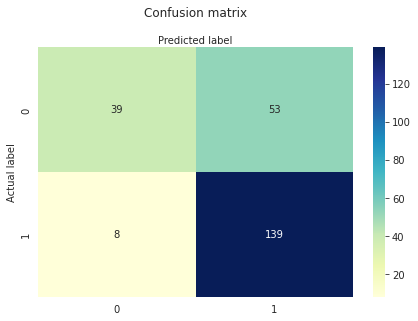

In [79]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=['Run','Pass'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_1), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [80]:
# get classification report
from sklearn.metrics import classification_report
target_names = ['run', 'pass']
print(classification_report(y_test, y_preds_1, target_names=target_names))

              precision    recall  f1-score   support

         run       0.83      0.42      0.56        92
        pass       0.72      0.95      0.82       147

    accuracy                           0.74       239
   macro avg       0.78      0.68      0.69       239
weighted avg       0.76      0.74      0.72       239



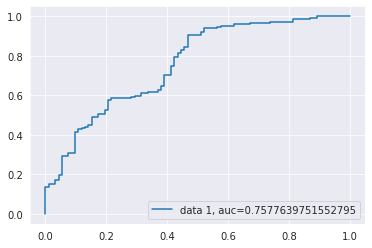

In [81]:
# Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.
# auc of 1 is perfect, .5 is worthless

y_pred_proba = log.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Model 1 Interpretation

Overall Accuracy: 74%

Correctly predicted 95% of actual passes as passes. But the model over predicts passes, and was not good at predicting run plays as it only predicted 42% of run plays correctly.



## Model 2: Same as Model 1 but with standardization/normalization

Using standardization/normalization from here on out.

## Model 3: Decision Tree With Max Depth = 3

## Model 4: Decision Tree with Max Depth = 6

## Model 5: Dense Neural Network, 2 hidden layers, 10 neurons

# Model Evaluation and Selection